# importing libraries and defining some important variables

In [29]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torch
from torch.utils.data import DataLoader ,Dataset
from torch import nn
import os
from torchvision import transforms as T
from torchvision import models
from sklearn.utils import shuffle
from sklearn.metrics import (confusion_matrix  ,precision_score ,recall_score
                             ,f1_score ,ConfusionMatrixDisplay)

# defining data directories
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Exploratory Data Analysis (EDA)

- first we should calculate the mean and std across all the images to normalize the images before feeding it to the model

In [88]:
means = []
stds = []
for folder in [train_dir ,val_dir ,test_dir]:
    sub_folders = os.listdir(folder)
    for sub_fold in sub_folders:
        images = os.listdir(os.path.join(folder ,sub_fold))
        print(f"{folder}/{sub_fold}")
        for image in tqdm(images):
            img = cv2.imread(os.path.join(folder ,sub_fold ,image) ,cv2.IMREAD_GRAYSCALE)
            img = img.astype(np.float32)/255
            means.append(img.mean(axis=(0,1)))
            stds.append(img.std(axis=(0,1)))

mean = np.stack(means).mean(axis=0)
std = np.stack(stds).mean(axis=0)
print(f"so the {mean=} and the {std=}")

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA


100%|██████████| 3875/3875 [00:29<00:00, 131.93it/s]


/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL


100%|██████████| 1341/1341 [00:29<00:00, 45.91it/s]


/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA


100%|██████████| 8/8 [00:00<00:00, 132.71it/s]


/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL


100%|██████████| 8/8 [00:00<00:00, 69.25it/s]


/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA


100%|██████████| 390/390 [00:02<00:00, 143.26it/s]


/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL


100%|██████████| 234/234 [00:03<00:00, 60.99it/s]

so the mean=0.4815148 and the std=0.22348984


- so the mean for the three channels : [0.48140758]<br/>
- and the std : [0.22343987]<br/>
- then we will resize the images to 299 X 299 to fit for inception v3 input shape

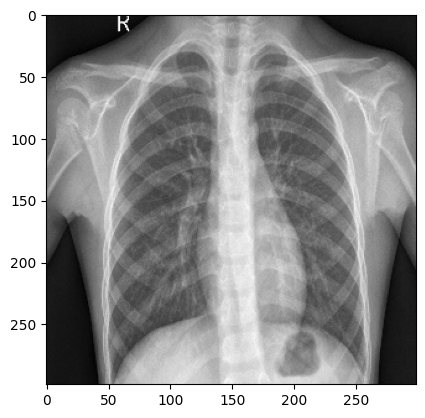

In [17]:
# plot an image as an example
img = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
                ,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img ,(299,299))
plt.imshow(img ,cmap="gray");

- plotting the distribution of classes through training data

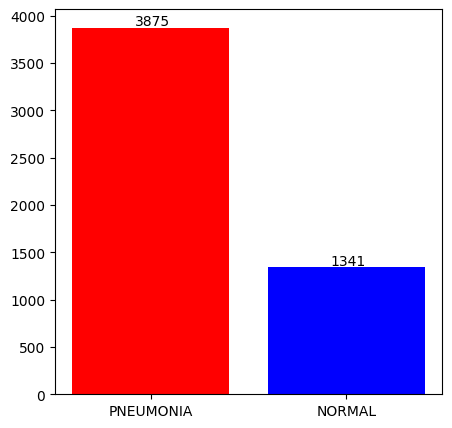

In [55]:
hist = {}
for folder in os.listdir(train_dir):
    label = folder
    hist[label] = 0
    for i in os.listdir(os.path.join(train_dir ,folder)):
        if i.startswith(".") : continue
        hist[label] += 1
        
plt.figure(figsize=(5,5))
x = np.array(list(hist.keys()))
y = np.array([hist[i] for i in x])
plt.bar(x ,y ,color=["r" ,"b"])
for i in range(len(x)):
    plt.text(i-0.08 ,y[i]+20 ,f"{y[i]}" ,color="black")
plt.show()

- so we will reduce the PNEUMONIA class to avoid overfitting
- then we will plot the distribution of classes through validation data

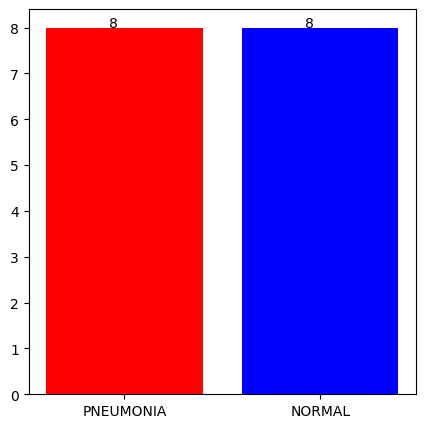

In [59]:
hist = {}
for folder in os.listdir(val_dir):
    label = folder
    hist[label] = 0
    for i in os.listdir(os.path.join(val_dir ,folder)):
        if i.startswith(".") : continue
        hist[label] += 1
        
plt.figure(figsize=(5,5))
x = np.array(list(hist.keys()))
y = np.array([hist[i] for i in x])
plt.bar(x ,y ,color=["r" ,"b"])
for i in range(len(x)):
    plt.text(i-0.08 ,y[i] ,f"{y[i]}" ,color="black")
plt.show()

- then we will plot the distribution of classes through testing data before 

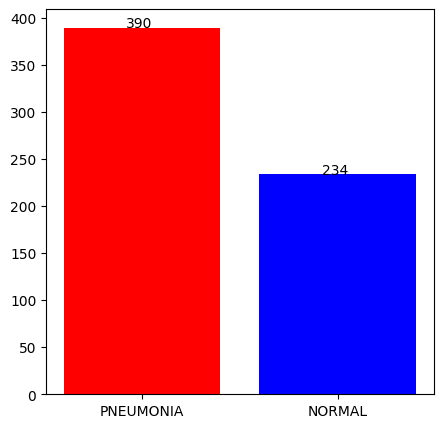

In [60]:
hist = {}
for folder in os.listdir(test_dir):
    label = folder
    hist[label] = 0
    for i in os.listdir(os.path.join(test_dir ,folder)):
        if i.startswith(".") : continue
        hist[label] += 1
        
plt.figure(figsize=(5,5))
x = np.array(list(hist.keys()))
y = np.array([hist[i] for i in x])
plt.bar(x ,y ,color=["r" ,"b"])
for i in range(len(x)):
    plt.text(i-0.08 ,y[i] ,f"{y[i]}" ,color="black")
plt.show()

- we will take part of the testing data as validation as it is the amount of validation is too small

In [2]:
# creating the list of the chosen images of testing folder
#with their labels for validation or testing

validation_list = [] 
for folder in os.listdir(test_dir):
    label = 0 if folder=="NORMAL" else 1
    for i in os.listdir(os.path.join(test_dir ,folder)):
        if i.startswith(".") : continue
        validation_list.append((i,label))
validation_list = shuffle(validation_list)
threshold = int(len(validation_list)*0.25)
testing_list =validation_list[threshold:]
validation_list = validation_list[:threshold]

# creating a Dataset generator and the dataloaders

In [3]:
class DataGenerator(Dataset):
    
    def __init__(self ,folder_dir ,training=True ,validation=False ,testing=False):
        """
        folder_dir : directory for train or validation or test data
        """
        super().__init__()
        dirs = []
        labels = []
        main_fol = []
        if not testing:
            for sub_dir in os.listdir(folder_dir):
                temp =  [i for i in os.listdir(os.path.join(folder_dir,sub_dir))
                     if not i.startswith(".")][:1341]
                dirs += temp
                if sub_dir == "NORMAL":
                    labels +=  [0 for _ in range(len(temp))]
                    main_fol += [folder_dir for _ in range(len(temp))]
                else:
                    labels += [1 for _ in range(len(temp))]
                    main_fol += [folder_dir for _ in range(len(temp))]
        
        if validation:
            for i in validation_list:
                dirs.append(i[0])
                labels.append(i[1])
                main_fol.append(test_dir)
        elif testing:
            for i in testing_list:
                dirs.append(i[0])
                labels.append(i[1])
                main_fol.append(test_dir)
        
        dirs,labels,main_fol = shuffle(dirs ,labels ,main_fol ,random_state=2509)
        self.dirs = dirs
        self.labels = labels
        self.main_fol = main_fol
        self.len = len(dirs)
        if training:
            self.transformations = T.Compose([
                T.ToTensor(),
                T.RandomRotation(15),
                T.RandomAdjustSharpness(1.6),
                T.Normalize((0.48140758,) ,(0.22343987,)),
                T.Resize((299,299)),
            ])
        else:
            self.transformations = T.Compose([
                T.ToTensor(),
                T.Normalize((0.48140758,) ,(0.22343987,)),
                T.Resize((299,299))
            ])
    
    def __len__(self):
        return self.len
    
    def __getitem__(self ,idx):
        label = self.labels[idx]
        if label:
                img = cv2.imread(os.path.join(self.main_fol[idx],"PNEUMONIA" ,self.dirs[idx])
                            ,cv2.IMREAD_GRAYSCALE) 
        else:
            img = cv2.imread(os.path.join(self.main_fol[idx] ,"NORMAL" ,self.dirs[idx])
                            ,cv2.IMREAD_GRAYSCALE)
        return self.transformations(img) ,torch.tensor(label ,dtype=torch.float32)

In [7]:
# testing the DataGenerator class
temp = DataGenerator(train_dir)
img,label = temp[0]
print(f"image shape :{img.shape} ,label :{label}")

image shape :torch.Size([1, 299, 299]) ,label :0.0


In [4]:
# craeting the datsets
train_dataset = DataGenerator(train_dir)
val_dataset = DataGenerator(val_dir ,training=False ,validation=True)
test_dataset = DataGenerator(test_dir ,training=False ,testing=True)

# creating the dataloaders
train_loader = DataLoader(train_dataset ,shuffle=True ,batch_size=32)
val_loader = DataLoader(val_dataset ,batch_size=32 ,shuffle=True)
test_loader = DataLoader(test_dataset ,batch_size=32)

In [141]:
# testing the datloaders 
iterator = iter(train_loader)
img,label = next(iterator)
print(f"image shape :{img.shape} ,label shape:{label.shape}")

image shape :torch.Size([32, 1, 299, 299]) ,label shape:torch.Size([32])


# Creating the model ,loss function

In [5]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv = nn.Conv2d(1,3,1,1)
        self.model = models.inception_v3(pretrained=False ,aux_logits=True)
        self.model.fc = nn.Sequential(nn.Linear(2048,1))
        self.model.AuxLogits.fc = nn.Sequential(nn.Linear(768,1))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self ,x ,training=True):
        x = self.conv(x)
        x = self.model(x)
        if training:
            logits = self.sigmoid(x.logits)
            aux_logits = self.sigmoid(x.aux_logits)
            return logits.reshape(-1) ,aux_logits.reshape(-1)
        else:
            x = self.sigmoid(x)
            return x.reshape(-1)

model = Model()
criteria = nn.BCELoss()

# finding the best learning rate (learning rate finder algorithm)

In [7]:
# setting the device suited for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# transfering the model to that device
model.to(device)

# setting the grid configuration
min_lr = 0.001
max_lr = 0.03
step_lr = 0.001

lr_losses = []
lr_values = np.arange(min_lr ,max_lr+step_lr ,step_lr)

# setting the optimizer
weight_decay = 0.0003
optimizer = torch.optim.Adam(model.parameters() ,lr=min_lr ,weight_decay=weight_decay)

# running an epoch for each learning rate value and find the loss
for lr in tqdm(lr_values ,desc="learning rate finder"):
    
    # updating the learning rate
    for g in optimizer.param_groups:
        g['lr'] = lr
        
    # reseting the model parameters
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    
    # one epoch loop
    losses = []
    for images,labels in train_loader:
        images,labels = images.to(device) ,labels.to(device) 
        predictions_logits ,predictions_aux_logits = model(images)
        optimizer.zero_grad()
        loss = criteria(predictions_logits ,labels)+(
               criteria(predictions_aux_logits ,labels)*0.2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    torch.cuda.empty_cache()
    losses = sum(losses)/len(losses)
    lr_losses.append(losses)

learning rate finder: 100%|██████████| 30/30 [3:23:15<00:00, 406.52s/it]  


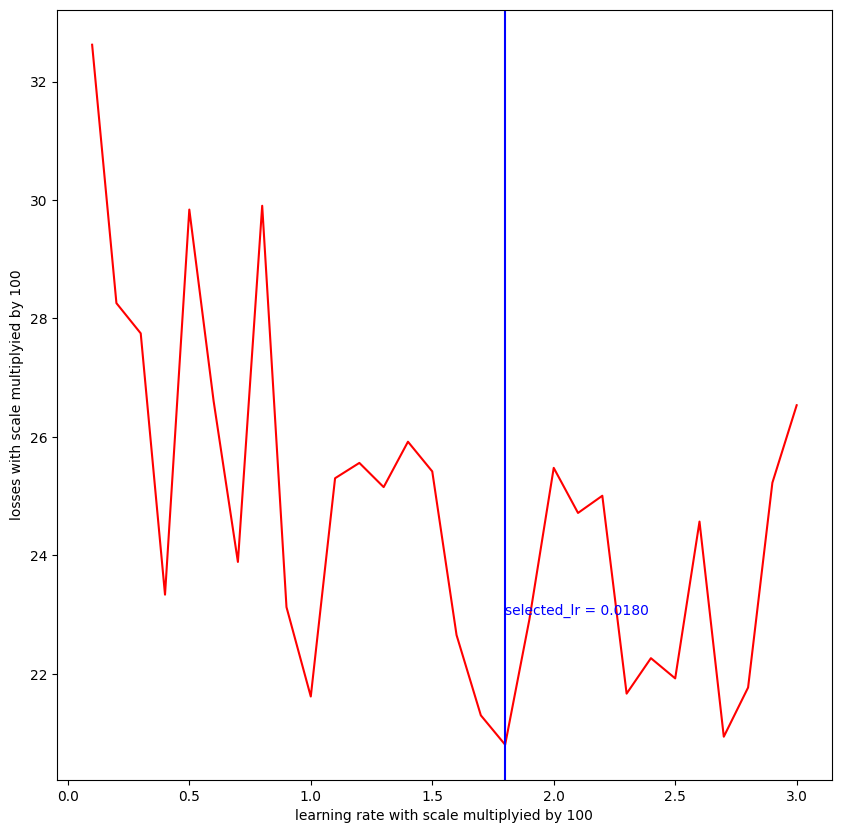

In [8]:
# plotting the results (we will scale the image to plot it)
scale = 100
x = lr_values*scale
y = np.array(lr_losses)*scale
loss_lr = y[0]
x_lr = x[0]
threshold = 0.002*scale
for i in range(len(x)):
    if y[i]<loss_lr and np.abs(loss_lr-y[i])>(threshold):
        loss_lr = y[i]
        x_lr = x[i]
plt.figure(figsize=(10,10))
plt.plot(x ,y ,color="red")
plt.axvline(x_lr ,color="blue")
plt.text(x_lr ,23 ,f"selected_lr = {x_lr/scale:.4f}" ,color="blue")
plt.xlabel(f"learning rate with scale multiplyied by {scale}")
plt.ylabel(f"losses with scale multiplyied by {scale}")
plt.show()

- so the learning rate will be 0.018

# training the model

In [10]:
# reseting the model parameters
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

# setting the device suited for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# transfering the model to that device
model.to(device)

# setting training variables
lr = 0.018
weight_decay = 0.0003
gamma = 0.9
step_size = 15
epochs = 150
epochs_losses = {"train":[] ,"vali":[]}
epochs_accuracy = {"train":[] ,"vali":[]}
patience = 10 # for early stopping
counter = patience # for early stopping
best_loss = np.inf # for early stopping
threshold = 0.02 # for early stopping

# initializing the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters() ,lr=lr ,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer ,step_size=step_size ,gamma=gamma)

# the training loop
for e in range(1,epochs+1):
    print(f"epoch : {e}/{epochs}")
    
    model.train()
    losses = []
    accuracy = []
    for images,labels in tqdm(train_loader ,desc="training process"):
        images,labels = images.to(device) ,labels.to(device)
        predictions_logits ,predictions_aux_logits = model(images)
        optimizer.zero_grad()
        loss = criteria(predictions_logits ,labels)+(
               criteria(predictions_aux_logits ,labels)*0.2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        accuracy.append((torch.sum(torch.round(predictions_logits) == labels)/len(images)).item())
    loss = sum(losses)/len(losses)
    accuracy = sum(accuracy)/len(accuracy)
    epochs_losses["train"].append(loss)
    epochs_accuracy["train"].append(accuracy)
    print(f"loss : {loss:.3f} ,accuracy : {accuracy*100:.3f}%")
    scheduler.step()
    torch.cuda.empty_cache()
    
    model.eval()
    losses = []
    accuracy = []
    for images,labels in tqdm(val_loader ,desc="validation process"):
        with torch.no_grad():
            images,labels = images.to(device) ,labels.to(device)
            predictions = model(images ,training=False)
            loss = criteria(predictions ,labels)
            losses.append(loss.item())
            accuracy.append((torch.sum(torch.round(predictions) == labels)/len(images)).item())
    loss = sum(losses)/len(losses)
    accuracy = sum(accuracy)/len(accuracy)
    epochs_losses["vali"].append(loss)
    epochs_accuracy["vali"].append(accuracy)
    print(f"loss : {loss:.3f} ,accuracy : {accuracy*100:.3f}%\n\n\n")
    torch.cuda.empty_cache()
    
    # early stopping
    if loss<best_loss and np.abs(best_loss-loss)>threshold:
        best_loss = loss
        torch.save(model.state_dict() ,"model.pt") # save the best model for inference
        counter = patience
    else:
        counter -= 1
    # break if overfitting
    if not counter: break

epoch : 1/150


training process: 100%|██████████| 84/84 [06:45<00:00,  4.82s/it]


loss : 0.266 ,accuracy : 91.232%


validation process: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


loss : 0.470 ,accuracy : 78.125%



epoch : 2/150


training process: 100%|██████████| 84/84 [06:44<00:00,  4.81s/it]


loss : 0.209 ,accuracy : 93.435%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


loss : 2.444 ,accuracy : 60.243%



epoch : 3/150


training process: 100%|██████████| 84/84 [06:49<00:00,  4.87s/it]


loss : 0.209 ,accuracy : 93.558%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


loss : 1.307 ,accuracy : 64.236%



epoch : 4/150


training process: 100%|██████████| 84/84 [06:36<00:00,  4.72s/it]


loss : 0.201 ,accuracy : 93.221%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


loss : 1.764 ,accuracy : 63.368%



epoch : 5/150


training process: 100%|██████████| 84/84 [06:47<00:00,  4.85s/it]


loss : 0.192 ,accuracy : 94.262%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


loss : 0.375 ,accuracy : 81.944%



epoch : 6/150


training process: 100%|██████████| 84/84 [06:49<00:00,  4.88s/it]


loss : 0.196 ,accuracy : 94.754%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


loss : 0.700 ,accuracy : 70.833%



epoch : 7/150


training process: 100%|██████████| 84/84 [06:42<00:00,  4.79s/it]


loss : 0.188 ,accuracy : 93.844%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


loss : 0.643 ,accuracy : 72.396%



epoch : 8/150


training process: 100%|██████████| 84/84 [06:40<00:00,  4.77s/it]


loss : 0.204 ,accuracy : 93.770%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


loss : 0.606 ,accuracy : 78.125%



epoch : 9/150


training process: 100%|██████████| 84/84 [06:34<00:00,  4.69s/it]


loss : 0.187 ,accuracy : 94.225%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


loss : 0.411 ,accuracy : 82.118%



epoch : 10/150


training process: 100%|██████████| 84/84 [06:27<00:00,  4.61s/it]


loss : 0.185 ,accuracy : 94.663%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


loss : 0.396 ,accuracy : 79.688%



epoch : 11/150


training process: 100%|██████████| 84/84 [06:24<00:00,  4.58s/it]


loss : 0.186 ,accuracy : 94.085%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


loss : 0.423 ,accuracy : 82.465%



epoch : 12/150


training process: 100%|██████████| 84/84 [06:28<00:00,  4.63s/it]


loss : 0.204 ,accuracy : 93.741%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


loss : 1.761 ,accuracy : 59.375%



epoch : 13/150


training process: 100%|██████████| 84/84 [06:28<00:00,  4.63s/it]


loss : 0.201 ,accuracy : 93.389%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


loss : 2.885 ,accuracy : 58.507%



epoch : 14/150


training process: 100%|██████████| 84/84 [06:41<00:00,  4.78s/it]


loss : 0.216 ,accuracy : 93.249%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


loss : 0.570 ,accuracy : 77.604%



epoch : 15/150


training process: 100%|██████████| 84/84 [06:37<00:00,  4.73s/it]


loss : 0.209 ,accuracy : 93.613%


validation process: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

loss : 0.668 ,accuracy : 74.479%





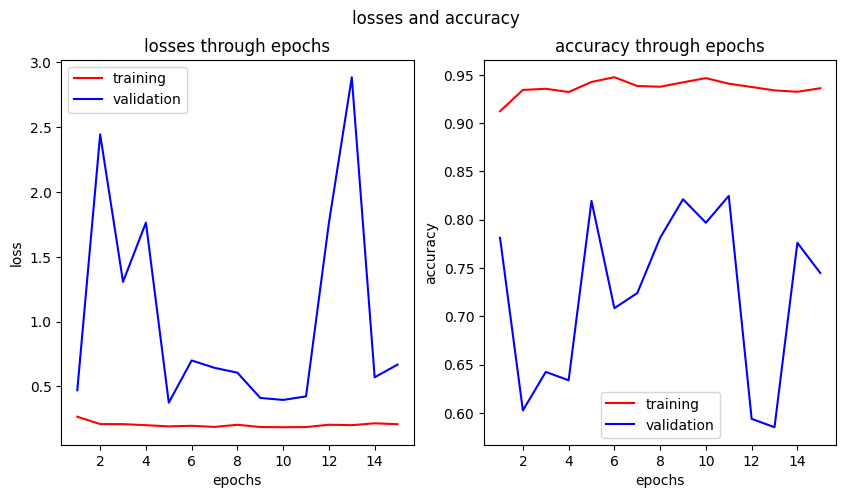

In [11]:
# plotting the results

plt.figure(figsize=(10,5))
plt.suptitle("losses and accuracy")

plt.subplot(1,2,1)
x = np.arange(1,e+1,1)
y = np.array(epochs_losses["train"])
plt.plot(x ,y ,color="red" ,label="training")
y = np.array(epochs_losses["vali"])
plt.plot(x ,y ,color="blue" ,label="validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("losses through epochs")

plt.subplot(1,2,2)
x = np.arange(1,e+1,1)
y = np.array(epochs_accuracy["train"])
plt.plot(x ,y ,color="red" ,label="training")
y = np.array(epochs_accuracy["vali"])
plt.plot(x ,y ,color="blue" ,label="validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy through epochs")
plt.show()

# testing the model

In [17]:
# reseting the model parameters
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
        
# loading the weights of the best model
model.to("cpu")
model.load_state_dict(torch.load('model.pt'))

# setting the device suited for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# transfering the model to that device
model.to(device)   
model.eval()

losses = []
accuracy = []

# for sikit-learn metrics
y_truth = []
y_pred = []

for images,labels in tqdm(test_loader ,desc="testing process"):
    with torch.no_grad():
        images,labels = images.to(device) ,labels.to(device)
        predictions = model(images ,training=False)
        loss = criteria(predictions ,labels)
        losses.append(loss.item())
        accuracy.append((torch.sum(torch.round(predictions) == labels)/len(images)).item())
        y_pred.append(torch.round(predictions).to("cpu").numpy())
        y_truth.append(labels.to("cpu").numpy())
loss = sum(losses)/len(losses)
accuracy = sum(accuracy)/len(accuracy)
print(f"loss : {loss:.3f} ,accuracy : {accuracy*100:.3f}%\n\n\n")
torch.cuda.empty_cache()

testing process: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]

loss : 0.412 ,accuracy : 82.042%





precision : 0.8275862068965517
f1 score : 0.8613376835236541
recall : 0.8979591836734694


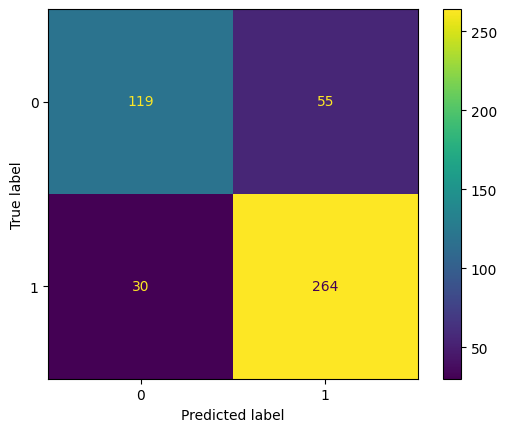

In [34]:
# sikit-learn metrics   
# 0 --> Normal , 1 --> Pneumonia
y_pred = np.concatenate(y_pred)
y_truth = np.concatenate(y_truth)
print("precision :" ,precision_score(y_truth ,y_pred))
print("f1 score :" ,f1_score(y_truth ,y_pred))
print("recall :" ,recall_score(y_truth ,y_pred))
conf_matrix = confusion_matrix(y_truth ,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();